# Analyse Rotation Spectra - Image Overview Hours


## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

from obspy import UTCDateTime
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path
# from scipy.stats import median_absolute_deviation as mad
from scipy.signal import welch

import os
import pickle
import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [4]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [5]:
def __get_mean_psd(psds):

    from numpy import mean, zeros, isnan

    mean_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        mean_psd[f] = mean(a[~isnan(a)])

    return mean_psd

In [6]:
def __get_minimum_psd(psds):
            
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum() 
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i   
    
    return psds[idx]

In [7]:
def __get_percentiles(arr):
    
    from numpy import zeros, nanpercentile
    
    percentiles_lower = zeros(shape(arr)[1])
    percentiles_upper = zeros(shape(arr)[1])

    for kk in range(shape(arr)[1]):
        out = nanpercentile(arr[:, kk],  [2.5 ,97.5])
        percentiles_upper[kk] = out[1]
        percentiles_lower[kk] = out[0]
        
    return percentiles_lower, percentiles_upper

In [8]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        columns = arange(0,df.shape[1]).astype(str)
        df.columns = columns
        print(" -> Failed to assign column names! Assigned numbers instead!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
    print(f" -> total of {df.shape[0]} psds")
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [9]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [10]:
# def __remove_noisy_psds(df, threshold_mean=1e-13):

#     from numpy import delete
    
#     l1 = len(df.columns)
#     for col in df.columns:
# #         print(col, type(col))
#         if df[col].astype(float).mean() > threshold_mean:
#             df = df.drop(columns=col)
#     l2 = len(df.columns)
#     print(f" -> removed {l1-l2} columns due to mean thresholds!")
#     print(f" -> {l2} psds remain")
    
#     return df

In [11]:
# os.listdir( f"{root_path}ROMY/RotationSpectra/data/" )

## Configurations

In [12]:
## _________________________________________________________


name = "ROMY-Z"
inname = "run_2019_ROMY-Z_3600_hours"
# threshold = 5e-20
# threshold = 1e-20
period_limits = 1, 200



## _________________________________________________________


inpath = f"{data_path}ROMY/RotationSpectra/data/{inname}/"

config = pickle.load(open(inpath+inname+"_config.pkl", 'rb'))

config['inname'] = inname
config['inpath'] = inpath
config['period_limits'] = period_limits

config['thres_romy'] = 5e-20
config['thres_rlas'] = 5e-21

config['outpath_figures'] = f"{data_path}LNM/figures_final/"

config['rlnm_model_path'] = f"{data_path}LNM/data/MODELS/"

config['frequency_limits'] = [1/config['period_limits'][1], 1/config['period_limits'][0]]


## Load as Arrays

In [13]:
def __load_data_files(config, path):
    
    from tqdm.notebook import tqdm
    from numpy import array
    
    print(path)
    
    config['files'] = [file for file in os.listdir(path) if "hourly" in file]
    config['files'].sort()

    psds_all, times_nom, times = [], arange(0, 24*365, 1), []
    count, missing  = 0, 0
    
    for file in tqdm(config['files']):
        date = file.split("_")[-2]
        psds_hourly = read_pickle(path+file)
        
        for h in range(24):
            try:
                psds_all.append(psds_hourly[h])
                times.append(times_nom[count])
            except:
                missing += 1
            count += 1
            
    print(f" -> missing: {missing}")
    return array(psds_all), times

In [14]:
ROMY_Z, ttimes_Z = __load_data_files(config, config['inpath']+config['inname']+"/".replace("Z","Z"))

fff_Z = pickle.load(open(f"{config['inpath'].replace('Z','Z')}{config['inname'].replace('Z','Z')}_frequency_axis.pkl", 'rb'))
ttimes_Z = pickle.load(open(f"{config['inpath'].replace('Z','Z')}{config['inname'].replace('Z','Z')}_times_axis.pkl", 'rb'))

/import/kilauea-data/ROMY/RotationSpectra/data/run_2019_ROMY-Z_3600_hours/run_2019_ROMY-Z_3600_hours/


  0%|          | 0/365 [00:00<?, ?it/s]

 -> missing: 0


In [15]:
RLAS_Z, times_Z = __load_data_files(config, (config['inpath']+config['inname']+"/").replace('ROMY-Z','RLAS-Z'))

ff_Z = pickle.load(open(f"{config['inpath'].replace('ROMY-Z','RLAS-Z')}{config['inname'].replace('ROMY-Z','RLAS-Z')}_frequency_axis.pkl", 'rb'))
times_Z = pickle.load(open(f"{config['inpath'].replace('Z','Z')}{config['inname'].replace('Z','Z')}_times_axis.pkl", 'rb'))

/import/kilauea-data/ROMY/RotationSpectra/data/run_2019_RLAS-Z_3600_hours/run_2019_RLAS-Z_3600_hours/


  0%|          | 0/365 [00:00<?, ?it/s]

 -> missing: 0


In [16]:
# shape(RLAS_Z), shape(ff_Z), shape(times_Z), shape(ROMY_Z), shape(fff_Z), shape(ttimes_Z)

In [17]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [18]:
ROMY_Z, fff_Z = __cut_frequencies_array(ROMY_Z, fff_Z, config['frequency_limits'][0], config['frequency_limits'][1])
RLAS_Z, ff_Z = __cut_frequencies_array(RLAS_Z, ff_Z, config['frequency_limits'][0], config['frequency_limits'][1])

## Remove Noisy PSDs

In [19]:
def __remove_noisy_psds(arr, times, threshold_mean=1e-16):

    from numpy import delete, shape, sort, array, nan
    
    l1 = shape(arr)[0]

    idx_to_remove = []
    for ii in range(shape(arr)[0]):
        
        ## appy upper threshold
        if arr[ii,:].mean() > threshold_mean:
            idx_to_remove.append(ii)
            
        ## apply default lowe threshold
        if arr[ii,:].mean() < 1e-26:
            idx_to_remove.append(ii)
            
    for jj in sort(array(idx_to_remove))[::-1]:
        
        ## option 1: delte rows
#         arr = delete(arr, jj, axis=0)
#         times = delete(times, jj, axis=0)

        ## option 2: replace with nan values
        arr[jj,:] = ones(len(arr[jj]))*nan
    
    l2 = shape(arr)[0]
    
    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")
    
    return arr, times

In [20]:
ROMY_Z, ttimes_Z = __remove_noisy_psds(ROMY_Z, ttimes_Z, threshold_mean=config['thres_romy'])
RLAS_Z, times_Z = __remove_noisy_psds(RLAS_Z, times_Z, threshold_mean=config['thres_rlas'])

 -> removed 0 rows due to mean thresholds!
 -> 8760 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 8760 psds remain


In [21]:
def __write_stats_mod(config, ff, arr, comp):

    out_df = DataFrame()

    out_df['frequencies'] = ff
    out_df['minimal'] = __get_minimal_psd(arr)
    out_df['median'] = __get_median_psd(arr)
    out_df['minimum'] = __get_minimum_psd(arr)
    out_df['mean'] = __get_mean_psd(arr)
    out_df['perc_lower'] = __get_percentiles(arr)[0]
    out_df['perc_upper'] = __get_percentiles(arr)[1]


    print(f" -> writing {config['inpath'].replace('ROMY-Z',comp)}{config['inname'].replace('ROMY-Z',comp)}_stats_mod.pkl")
    out_df.to_pickle(f"{config['inpath'].replace('ROMY-Z',comp)}{config['inname'].replace('ROMY-Z',comp)}_stats_mod.pkl")

In [22]:
# __write_stats_mod(config, fff_Z, ROMY_Z, "ROMY-Z")
# __write_stats_mod(config, ff_Z, RLAS_Z, "RLAS-Z")

## Plotting

### Plot Version 1

In [23]:
def __makeplot_image_overview(ff, psds, times, one_colorbar=False):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors


    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp = 1/ff[mm]
        pp.append(ppp)

    ##____________________________

    NN = 2

    fig, axes = plt.subplots(NN, 1, figsize=(12,12), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.05)

    font = 14

    N = int(24*365)

    if one_colorbar:
        max_psds = max(nanmax(psds[0]), nanmax(psds[1]))
        min_psds = min(nanmin(psds[0]), nanmin(psds[1]))

    cmap = plt.colormaps.get_cmap('rainbow')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')
    cmap.set_bad('white',0.3)


    for j in tqdm(range(NN)):

        if not one_colorbar:
            max_psds = nanmax(psds[j])
            min_psds = nanmin(psds[j])


        im = axes[j].pcolormesh(times[j], 1/ff[j], psds[j].T, 
                                cmap=cmap,
                                norm=colors.LogNorm(vmax=max_psds,vmin=min_psds*1e1,),
                                )

        axes[j].tick_params(labelsize=font-2)


        axes[j].set_ylim(config['period_limits'][0], config['period_limits'][1]-10)
        axes[j].set_yscale("log")

        if not one_colorbar:
            ## set individual colorbars
            cbar = fig.colorbar(im, orientation='vertical', ax=axes[j], aspect=15, pad=0.01)
            cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-53)

    axes[NN-1].set_xlabel("Days of 2019", fontsize=font, labelpad=-1)

    new_ticks = [int(round(t/24,0)) for t in axes[NN-1].get_xticks()]
    axes[NN-1].set_xticklabels(new_ticks)

    ## panel labels
    axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)

    ## data labels
    axes[0].text(.99, .99, f' ROMY Z', ha='right', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.99, .99, f'G-ring Z', ha='right', va='top', transform=axes[1].transAxes, fontsize=font)


    axes[0].set_ylabel(r"Periods (s)", fontsize=font)
    axes[1].set_ylabel(r"Periods (s)", fontsize=font)

    if one_colorbar:
        ## set joint colorbar
        cbar = fig.colorbar(im, orientation='vertical', ax=axes.ravel().tolist(), aspect=30, pad=0.01)
        cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-53)

    plt.show();
    return fig

  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_194048/1217298050.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[NN-1].set_xticklabels(new_ticks)


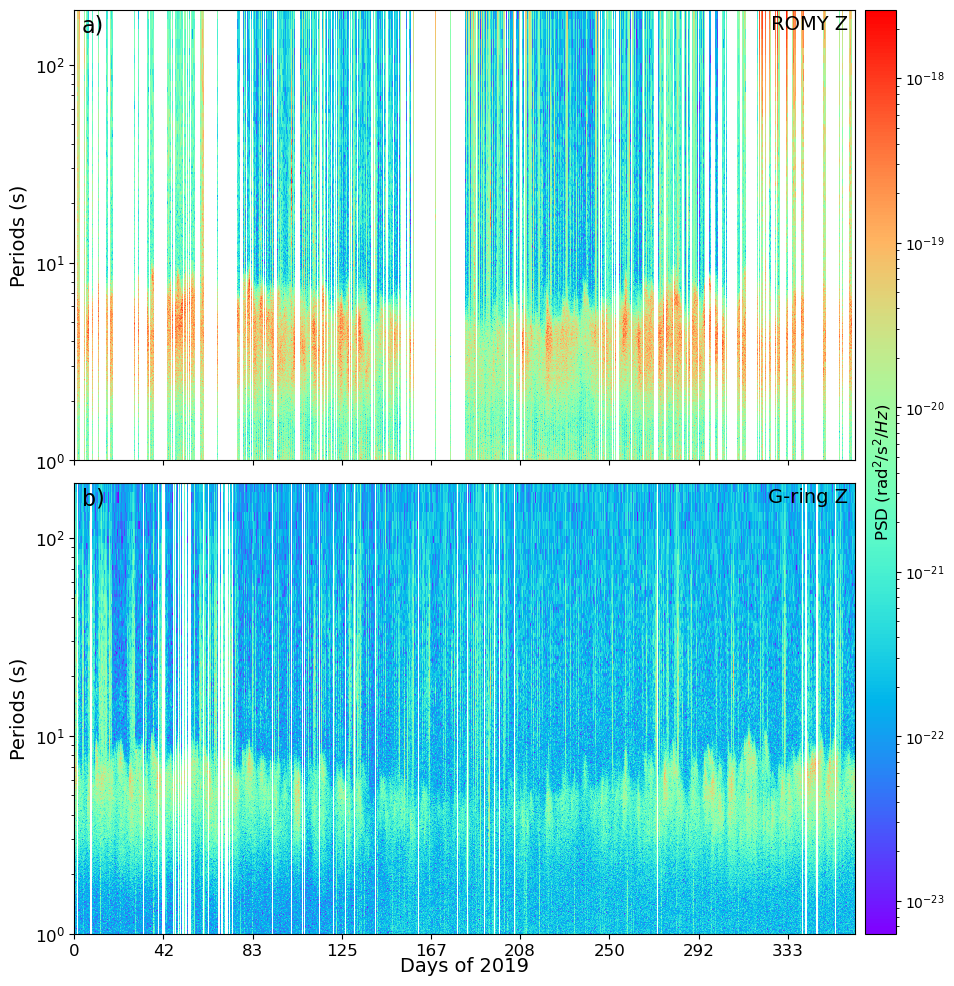

In [24]:
fig = __makeplot_image_overview([fff_Z, ff_Z],
                                [ROMY_Z, RLAS_Z],
                                [ttimes_Z, times_Z],
                                one_colorbar=True)

In [25]:
# __savefig(fig, outpath=config['outpath_figures'], outname=f"ringlaser_psdimage_final", mode="png", dpi=100)

### Plot Version2

In [26]:
def __makeplot_image_overview2(ff, psds, times):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors


    ## theoretical rlnm
    rlnm = read_csv(config['rlnm_model_path']+"rlnm_theory.csv")

    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp = 1/ff[mm]
        pp.append(ppp)

    ## define colormap
    cmap = plt.colormaps.get_cmap('rainbow')
    cmap.set_bad(color='white')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')

    ## compute overall maxima and minima
    max_psds = max(nanmax(psds[0]), nanmax(psds[1]))
    min_psds = min(nanmin(psds[0]), nanmin(psds[1]))


    ##____________________________

#     NN = 3
    N = int(24*365)

    font = 14

    fig = plt.figure(constrained_layout=False, figsize=(10,8))
    widths = [5, 2]
    heights = [1, 1]
    spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

    plt.subplots_adjust(hspace=0.1, wspace=0.03)

    ax1_1 = fig.add_subplot(spec[0, 0])
    ax1_2 = fig.add_subplot(spec[0, 1], sharey=ax1_1)
    ax2_1 = fig.add_subplot(spec[1, 0], sharex=ax1_1)
    ax2_2 = fig.add_subplot(spec[1, 1], sharey=ax2_1)


    im1 = ax1_1.pcolormesh( times[0], 1/ff[0], psds[0].T,
                            cmap=cmap,
                            norm=colors.LogNorm(vmax=nanmax(psds[0]), vmin=nanmin(psds[0])*1e1),
                            )
    im2 = ax2_1.pcolormesh( times[1], 1/ff[1], psds[1].T,
                            cmap=cmap,
                            norm=colors.LogNorm(vmax=nanmax(psds[1]), vmin=nanmin(psds[1])*1e1),
                            )


    perc_lower, perc_upper = __get_percentiles((psds[0]))
    ax1_2.fill_betweenx(pp[0], perc_lower, perc_upper, color='darkred', zorder=3, alpha=0.4, label="")
    ax1_2.plot(__get_median_psd(psds[0]), pp[0], color='darkred', zorder=3, alpha=0.9, label="Median")
    ax1_2.plot(rlnm['rlnm_psd_median'], rlnm['period'], color="black", zorder=2, ls="--", lw=2)

    perc_lower, perc_upper = __get_percentiles((psds[1]))
    ax2_2.fill_betweenx(pp[1], perc_lower, perc_upper, color='darkred', zorder=3, alpha=0.4, label="")
    ax2_2.plot(__get_median_psd(psds[1]), pp[1], color='darkred', zorder=3, alpha=0.9, label="Median")
    ax2_2.plot(rlnm['rlnm_psd_median'], rlnm['period'], color="black", zorder=2, ls="--", lw=2)


    plt.setp(ax1_1.get_xticklabels(), visible=False)
    plt.setp(ax1_2.get_xticklabels(), visible=False)

    plt.setp(ax1_2.get_yticklabels(), visible=False)
    plt.setp(ax2_2.get_yticklabels(), visible=False)


    for ax in [ax1_1, ax1_2, ax2_1, ax2_2]:
        ax.tick_params(labelsize=font-2)
        ax.set_ylim(config['period_limits'][0], config['period_limits'][1]-18)
        ax.set_yscale("log")

    for ax in [ax1_2, ax2_2]:
        ax.set_xscale("logit")

    ax2_1.set_xlabel("Days of 2019", fontsize=font, labelpad=1)
    ax2_2.set_xlabel(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font, labelpad=-1)

    new_ticks = [int(round(t/24,0)) for t in ax2_1.get_xticks()]
    ax2_1.set_xticklabels(new_ticks)

#     ## panel labels
    ax1_1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1_1.transAxes, fontsize=font+2)
    ax2_1.text(.01, .99, '(b)', ha='left', va='top', transform=ax2_1.transAxes, fontsize=font+2)

#     ## data labels
    array = name.split("_")[0]
    ax1_1.text(.99, .99, f'ROMY Z', ha='right', va='top', transform=ax1_1.transAxes, fontsize=font)
    ax2_1.text(.99, .99, f'G-ring Z', ha='right', va='top', transform=ax2_1.transAxes, fontsize=font)

    ax1_1.set_ylabel(r"Periods (s)", fontsize=font)
    ax2_1.set_ylabel(r"Periods (s)", fontsize=font)


    ## set individual colorbars
    cbar = fig.colorbar(im1, orientation='vertical', ax=ax1_2, pad=0.1)
    cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-59)

    cbar = fig.colorbar(im2, orientation='vertical', ax=ax2_2, pad=0.1)
    cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-59)

#     ## set colorbar at bottom
#     cbar = fig.colorbar(im1, orientation='vertical', ax=[ax1_2, ax2_2], aspect=33, pad=0.05)
#     cbar.set_label(r"PSD (rad$^2$/s$^2$/$Hz$)", fontsize=font-2, labelpad=-50)

    plt.show();
    return fig

/tmp/ipykernel_194048/3673949212.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2_1.set_xticklabels(new_ticks)


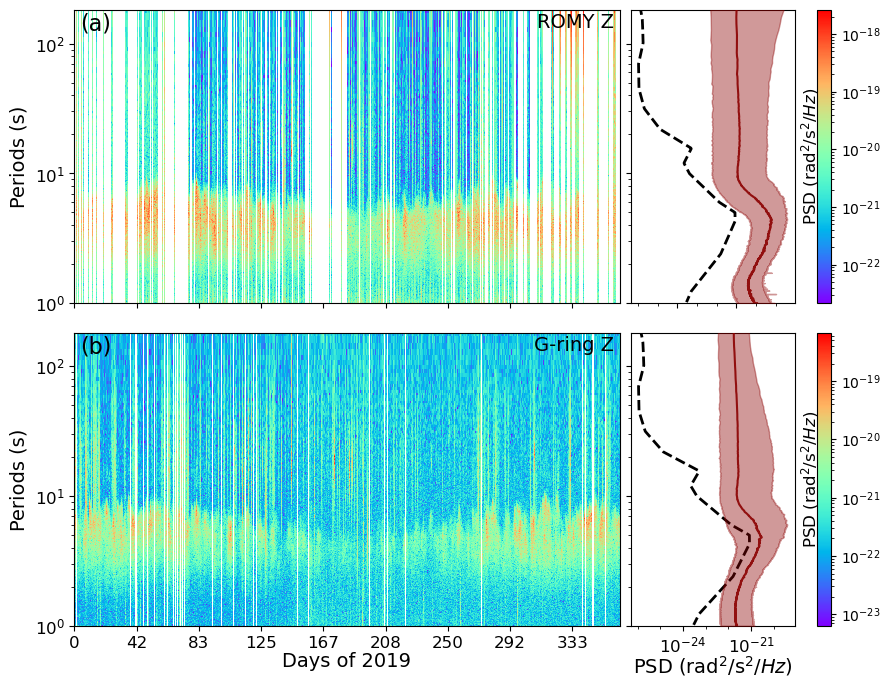

In [27]:
fig = __makeplot_image_overview2([fff_Z, ff_Z],
                                [ROMY_Z, RLAS_Z],
                                [ttimes_Z, times_Z],
                                )

In [28]:
fig.savefig("/home/brotzer/Documents/ROMY/LowNoiseModel/SRL/figures/300dpi/"+"figure2.tiff", format="tiff", bbox_inches="tight", dpi=200, transparent=None)

In [29]:
__savefig(fig, outpath=config['outpath_figures'], outname=f"ringlaser_psdimage_final2", mode="png", dpi=300)


   -> saving /import/kilauea-data/LNM/figures_final/ringlaser_psdimage_final2.png ...

   -> Done



## Limit it by computing medians 

In [30]:
def __makeplot_colorlines_overview(ff, psds, dates=None):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)

    ## theoretical rlnm
    rlnm = read_csv(config['rlnm_model_path']+"rlnm_theory.csv")

    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp[:-1] = 1/ff[mm][1:]
        pp.append(ppp)

    ##____________________________

    NN = 3

    fig, axes = plt.subplots(NN,1, figsize=(10,10), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = max(psds[0].shape[0], psds[1].shape[0], psds[2].shape[0])
    colors = plt.cm.rainbow(linspace(0, 1, N))

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = axes[0].secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-5)
    ax2.set_xticklabels(ff[2], fontsize=11)    
    ax2.tick_params(axis='both', labelsize=font-2)


    for j in range(NN):
        for n, psd in enumerate(tqdm(psds[j])):
            axes[j].loglog(pp[j], psd, color=colors[n], alpha=0.7)
            p2 = axes[j].scatter(pp[j][0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)

        axes[j].loglog(pp[j], __get_minimum_psd(psds[j], ff[j]), 'grey', zorder=3, alpha=0.9, label="Minimum")
        axes[j].loglog(pp[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.9, label="Median")
        axes[j].loglog(rlnm['period'], rlnm['rlnm_psd_median'], color="black", zorder=2, ls="--", lw=2)

        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)

        axes[j].text(6, 5e-25, "RLNM", fontsize=font, rotation=-30)

        axes[j].set_xlim(config['period_limits'][0],config['period_limits'][1])
#         axes[j].set_ylim(8e-27, 1e-17)


    axes[NN-1].set_xlabel("  Period (s)", fontsize=font, labelpad=-8)

    ## panel labels
    axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
    axes[2].text(.01, .99, 'c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)


    axes[0].set_ylabel(r"PSD$_{vertical}$ (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    axes[1].set_ylabel(r"PSD$_{north}$ (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    axes[2].set_ylabel(r"PSD$_{east}$ (rad$^2$/s$^2$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5)


    ## redefine ticks of colorbar
    if dates is not None:
        new_ticks = []
        for t in cbar.get_ticks():
            new_ticks.append(dates.astype(str)[int(t)])
        cbar.ax.set_yticklabels(new_ticks)

    plt.show();
    return fig

In [31]:
def __compute_medians(arr, intervall=100):

    delta_i = int(intervall)
    d1, d2 = 0, delta_i

    meds = zeros((int(len(arr)/delta_i), shape(arr)[1]))
    idx = 0
    while d2 < len(arr):
        meds[idx] = __get_median_psd(arr[d1:d2,:])
        idx +=1
        d1 += delta_i
        d2 += delta_i

    return meds

In [32]:
meds_N = __compute_medians(ADR_N, intervall=24)
meds_E = __compute_medians(ADR_E, intervall=24)
meds_Z = __compute_medians(ADR_Z, intervall=24)

NameError: name 'ADR_N' is not defined

In [ ]:
nn = 100
tmp = linspace(0, shape(ADR_Z)[0], shape(ADR_Z)[0])

fig = __makeplot_colorlines_overview([ff_Z, ff_N, ff_E], [meds_Z, meds_N, meds_E], dates=tmp)

In [ ]:
# __savefig(fig, outpath=config['outpath_figures'], outname=f"{name}_colorlines_selection", mode="png", dpi=300)

## OLD PLOTS

## Calculate and Plot Density

In [ ]:
# output = __calculate_density(psds, bins=100, density=True)

In [ ]:
# def __makeplot_PPSD(ff, output, config, mode=None):

#     from matplotlib import colors
#     from numpy import ones, convolve, array, log10, roll, sqrt

#     bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
#     if mode is "DB":
#         y_axis = 10*log10(bins)
#     elif mode is "PSD":
#         y_axis = bins
#     elif mode is "ASD":
#         y_axis = sqrt(bins)
        
#     x_axis = ff

#     ## plotting
#     fig, ax = plt.subplots(1,1,figsize=(13,6))

#     font=14

#     cmap = plt.cm.get_cmap('magma_r')
# #     cmap = plt.cm.get_cmap('gray_r')
#     cmap.set_under(color='white')

#     im = plt.pcolor(x_axis, y_axis, dist.T, 
#                     cmap=cmap,
#                     vmin=1e-12, 
#                     alpha=0.99,
#                    )

#     ## add Frequency Axis
#     g = lambda x: 1/x
#     ax2 = ax.secondary_xaxis("top", functions=(g,g))
#     ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
#     ax2.set_xticklabels(1/ff, fontsize=11)    
    
    
#     if mode is "DB":
#         plt.plot(x_axis, 10*log10(bins_medians), color='black', alpha=0.5, label="RNLM")
#         plt.ylim(-200, -80)

#     elif mode is "PSD":
#         plt.plot(x_axis, bins_medians, color='black', alpha=0.5, label="RNLM")
#         plt.yscale('log')
#         plt.ylim(10**-20, 10**-13)
  
#     elif mode is "ASD":  
#         plt.plot(x_axis, sqrt(bins_medians), color='black', alpha=0.5, label="RNLM")
#         plt.yscale('log')
#         plt.ylim(10**-10, 2*10**-7)

    
# #     plt.fill_betweenx(range(-270, -140), x1=0, x2=2.5, color="grey", alpha=0.4)
# #     plt.fill_betweenx(range(-270, -140), x1=200, x2=max(ff), color="grey", alpha=0.4)

#     ## modify x-axis
#     plt.xscale('log')
#     plt.xlim([min(x_axis), max(x_axis)])
# #     plt.xlim(1, 300)
    
#     ## add colorbar
#     caxes = fig.add_axes()
#     cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    
#     if output['set_density']:
#         cb.set_label("Propability Density", fontsize=font)
#     else:
#         cb.set_label("Counts", fontsize=font)
#         cb.set_label("Propability Density", fontsize=font)
    
#     if mode is "DB":
# #         plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
#         plt.ylabel(r"PPSD in dB (rel. to 1 rad$^2$/s$^2$/$Hz$)", fontsize=font)
#     elif mode is "PSD":
# #         plt.ylabel(r"PPSD in m$^4$/s$^2$/$Hz$", fontsize=font)
#         plt.ylabel(r"PPSD in $\frac{rad^2}{s^2 Hz}$", fontsize=font)
#     elif mode is "ASD":
#         plt.ylabel(r"PASD in $\frac{rad}{s \sqrt{Hz}}$", fontsize=font)
        
#     plt.grid(axis="both", which="both", ls="--", zorder=0)
#     plt.legend()
    
#     plt.xlabel("Period in seconds", fontsize=font)

#     plt.tick_params(axis='both', labelsize=font-2)

#     plt.show();
#     return fig

In [ ]:
# fig = __makeplot_PPSD(ff, output, config, mode="ASD")